In [1]:
ROBBER = "R"
POLICE = "P"
BANK = "B"
EMPTY = "*"

grid = [
    [ROBBER,EMPTY,EMPTY,EMPTY],
    [EMPTY,BANK,EMPTY,EMPTY],
    [EMPTY,EMPTY,EMPTY,EMPTY],
    [EMPTY,EMPTY,EMPTY, POLICE]
]

for row in grid:
    print(' '.join(row))

R * * *
* B * *
* * * *
* * * P


In [2]:
class State:
    
    def __init__(self, robber_pos, police_pos):
        self.robber_pos = robber_pos
        self.police_pos = police_pos
        
    def __eq__(self, other):
        return isinstance(other, State) and self.robber_pos == other.robber_pos and self.police_pos == other.police_pos
    
    def __hash__(self):
        return hash(str(self.robber_pos) + str(self.police_pos))
    
    def __str__(self):
        return f"State(robber_pos={self.robber_pos}, police_pos={self.police_pos})"

In [3]:
STAY = 0
UP = 1
DOWN = 2 
LEFT = 3
RIGHT = 4

ACTIONS = [STAY, UP, DOWN, LEFT, RIGHT]

REWARD_BANK = 1
REWARD_EMPTY = 0
REWARD_CAUGHT = -10

START_ROBBER = [0,0]
START_POLICE = [3,3]

In [4]:
start_state = State(robber_pos=START_ROBBER, police_pos=START_POLICE)

In [5]:
from copy import deepcopy

def act(state,action_robber,action_police):
    def new_actor_pos(state,state_actor_pos,action):
        p = deepcopy(state_actor_pos)
        if action == UP:
            p[0] = max(0,p[0]-1)
        elif action == DOWN:
            p[0] = min(3, p[0]+1)
        elif action == LEFT:
            p[1] = max(0, p[1]-1)
        elif action == RIGHT:
            p[1] = min(3, p[1]+1)
        elif action == STAY:
            p = p
        else:
            raise ValueError(f"Unknown action {action}")
        return p
    
    pos_robber = new_actor_pos(state,state.robber_pos,action_robber)
    pos_police = new_actor_pos(state,state.police_pos,action_police)
    
    if pos_robber == pos_police:
        reward = REWARD_CAUGHT
    elif pos_robber == [1,1]:
        reward = REWARD_BANK
    else:
        reward = REWARD_EMPTY
        
    return State(robber_pos=pos_robber, police_pos=pos_police), reward


    

In [6]:
import numpy as np
import random
random.seed(42)

N_STATES = 16*16
ITERATIONS = 1000000#0

eps = 1#0.2
LAMBDA = 0.8

q_table = dict()


In [7]:
def q(state, action_robber=None):
    
    if state not in q_table:
        q_table[state] = np.zeros(len(ACTIONS))
    if action_robber is None: 
        return q_table[state]
    
    return q_table[state][action_robber]



In [8]:
def choose_action(state):
    pos_robber = state.robber_pos
    pos_police = state.police_pos
    if pos_police[0] == 0:
        if pos_police[1] == 0:
            action_police = random.choice([ACTIONS[2],ACTIONS[4]])
        elif pos_police[1] == 3:
            action_police = random.choice([ACTIONS[2],ACTIONS[3]])
        else:
            action_police = random.choice(ACTIONS[2:5])
    elif pos_police[0] == 3:
        if pos_police[1] == 0:
            action_police = random.choice([ACTIONS[1],ACTIONS[4]])
        elif pos_police[1] == 3:
            action_police = random.choice([ACTIONS[1],ACTIONS[3]])
        else:
            action_police = random.choice([ACTIONS[1],ACTIONS[3],ACTIONS[4]])
    elif pos_police[1] == 0:
        action_police = random.choice([ACTIONS[1],ACTIONS[2],ACTIONS[4]])
    elif pos_police[1] == 3:
        action_police = random.choice(ACTIONS[1:4])
    else: 
        action_police = random.choice(ACTIONS[1:])
        
    if random.uniform(0, 1) < eps:   
        if pos_robber[0] == 0:
            if pos_robber[1] == 0:
                action_robber = random.choice([ACTIONS[0],ACTIONS[2],ACTIONS[4]])
            elif pos_robber[1] == 3:
                action_robber = random.choice([ACTIONS[0],ACTIONS[2],ACTIONS[3]])
            else:
                action_robber = random.choice([ACTIONS[0],ACTIONS[2],ACTIONS[3],ACTIONS[4]])
        elif pos_robber[0] == 3:
            if pos_robber[1] == 0:
                action_robber = random.choice([ACTIONS[0],ACTIONS[1],ACTIONS[4]])
            elif pos_robber[1] == 3:
                action_robber = random.choice([ACTIONS[0],ACTIONS[1],ACTIONS[3]])
            else:
                action_robber = random.choice([ACTIONS[0],ACTIONS[1],ACTIONS[3],ACTIONS[4]])
        elif pos_robber[1] == 0:
            action_robber = random.choice([ACTIONS[0],ACTIONS[1],ACTIONS[2],ACTIONS[4]])
        elif pos_robber[1] == 3:
            action_robber = random.choice(ACTIONS[0:4])
        else: 
            action_robber = random.choice(ACTIONS)
    else:
        action_robber = np.argmax(q(state))
    
    return action_robber, action_police


In [9]:
index_matrix = np.arange(16).reshape((4,4))
state_index_matrix = np.arange(16*16).reshape((16,16))
policy_matrix = np.zeros((16,16))+10 # 10, to make sure an action is choosen in all states

def state_matrix(state):
    pos_police = state.police_pos
    pos_robber = state.robber_pos
    # police along rows, robber along columns
    col_r = index_matrix[pos_robber[0]][pos_robber[1]]
    row_p = index_matrix[pos_police[0]][pos_police[1]]
    state_index = state_index_matrix[row_p][col_r]
    
    best_move = np.argmax(q(state))
    policy_matrix[row_p][col_r] = best_move
    
    return(state_index)

In [10]:
state = start_state
total_reward = 0

values = []
times = []
rewards = []

n_updates_Q = np.zeros((len(ACTIONS),16*16))

for t in range(ITERATIONS):
    
    action_robber, action_police = choose_action(state)
    next_state, reward = act(state, action_robber, action_police)
    total_reward += reward

    state_index = state_matrix(state)
    n_updates_Q[action_robber][state_index] += 1
    alpha = 1/(n_updates_Q[action_robber][state_index]**(2/3))

    q(state)[action_robber] = q(state, action_robber) + \
            alpha * (reward + LAMBDA *  np.max(q(next_state)) - q(state, action_robber))
    
    if t%1000==0:
        # Look at the first state taking the action with max q value
        values.append(max(q(start_state)))
        times.append(t)
        rewards.append(total_reward)
        #print(max(q(start_state)))
        #print(t) 

    state = next_state

print(n_updates_Q)

[[634. 669. 663. ... 629. 666. 714.]
 [  0.   0.   0. ... 683. 653. 652.]
 [637. 606. 682. ...   0.   0.   0.]
 [  0. 632. 649. ... 644. 686. 684.]
 [649. 626. 692. ... 661. 680.   0.]]


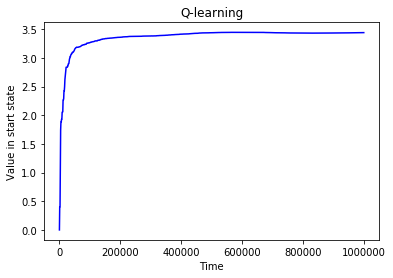

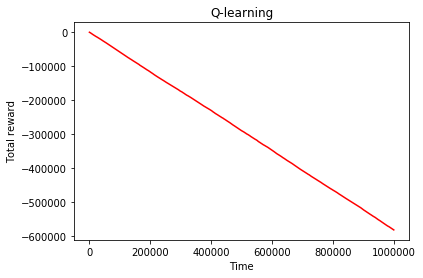

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(times,values,'b')
plt.title("Q-learning")
plt.xlabel("Time")
plt.ylabel("Value in start state")
plt.show()

plt.plot(times,rewards,'r')
plt.title("Q-learning")
plt.xlabel("Time")
plt.ylabel("Total reward")
plt.show()

In [12]:
print(len(q_table))

256


In [13]:
def get_spec_policy(grid_index_police):
    print(policy_matrix)
    fixed_police = policy_matrix[grid_index_police]
    fixed_police_policy = fixed_police.reshape(4,4)
    police_idx = np.where(index_matrix==grid_index_police)
    fixed_police_policy[police_idx[0][0]][police_idx[1][0]] = 9
    print(fixed_police_policy)
get_spec_policy(5)

[[0. 2. 0. 3. 4. 0. 3. 3. 0. 1. 0. 3. 1. 1. 1. 3.]
 [2. 0. 2. 0. 0. 1. 0. 3. 1. 0. 1. 3. 1. 1. 3. 1.]
 [2. 2. 0. 2. 4. 0. 3. 0. 4. 1. 3. 3. 4. 1. 3. 3.]
 [2. 2. 2. 0. 4. 0. 3. 3. 4. 1. 3. 3. 1. 1. 3. 1.]
 [4. 0. 3. 3. 0. 2. 0. 3. 4. 0. 1. 3. 0. 1. 1. 1.]
 [0. 2. 0. 3. 4. 0. 3. 0. 0. 1. 0. 3. 1. 0. 1. 3.]
 [4. 0. 2. 0. 0. 1. 0. 3. 1. 0. 1. 0. 1. 1. 3. 1.]
 [2. 2. 3. 3. 4. 0. 3. 0. 1. 1. 3. 3. 1. 1. 3. 3.]
 [4. 2. 2. 3. 4. 0. 3. 3. 0. 1. 1. 3. 4. 0. 1. 1.]
 [4. 0. 2. 3. 0. 1. 0. 3. 1. 0. 3. 1. 0. 1. 0. 3.]
 [2. 2. 3. 3. 4. 0. 3. 0. 1. 1. 0. 3. 4. 0. 3. 0.]
 [4. 2. 2. 3. 4. 0. 3. 3. 4. 1. 3. 0. 1. 1. 3. 3.]
 [2. 2. 3. 3. 4. 0. 3. 3. 1. 1. 1. 3. 0. 1. 1. 1.]
 [2. 2. 2. 3. 4. 0. 3. 3. 1. 1. 1. 3. 1. 0. 1. 1.]
 [4. 2. 2. 3. 4. 0. 3. 3. 1. 1. 3. 1. 1. 1. 0. 3.]
 [4. 2. 2. 3. 4. 0. 3. 3. 1. 1. 1. 3. 4. 1. 1. 0.]]
[[0. 2. 0. 3.]
 [4. 9. 3. 0.]
 [0. 1. 0. 3.]
 [1. 0. 1. 3.]]


In [14]:
print(n_updates_Q)
print(q(start_state))

[[634. 669. 663. ... 629. 666. 714.]
 [  0.   0.   0. ... 683. 653. 652.]
 [637. 606. 682. ...   0.   0.   0.]
 [  0. 632. 649. ... 644. 686. 684.]
 [649. 626. 692. ... 661. 680.   0.]]
[2.63556199 0.         3.43971695 0.         3.44017278]
